# Benchmarking GFLOPS with Cloudbutton

In [8]:
%pylab inline
import numpy as np
import time
import flops_benchmark
import pandas as pd
from six.moves import cPickle as pickle
import seaborn as sns
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


# Step by Step instructions

We are going to benchmark the simple function below, which simply generates two matrices and computes their matrix (dot) product. The matrices are of size `MAT_N` and we will compute the product `loopcount` times. 

In [9]:
def compute_flops(loopcount, MAT_N):
    
    A = np.arange(MAT_N**2, dtype=np.float64).reshape(MAT_N, MAT_N)
    B = np.arange(MAT_N**2, dtype=np.float64).reshape(MAT_N, MAT_N)

    t1 = time.time()
    for i in range(loopcount):
        c = np.sum(np.dot(A, B))

    FLOPS = 2 *  MAT_N**3 * loopcount
    t2 = time.time()
    return FLOPS / (t2-t1)

All of the actual benchmark code is in a stand-alone python file, which you can call as follows. It places the output in `small.pickle`.
If you are interested in the details you can inspect the [flops_benchmark.py](flops_benchmark.py) file. Here is the relevant code snippet that invokes the distirbuten PyWren functions:

```python
iters = np.arange(N)

def f(x):
    return {'flops': compute_flops(loopcount, matn)}

pwex = pywren.ibm_cf_executor(runtime_memory=1024)
futures = pwex.map(f, iters)

```

In [10]:
COMPUTE_BACKEND='aliyun_fc'

In [11]:
WORKERS=1000

In [27]:
# Parallel Function limit of 1000 simultaneous invocations
!python3 flops_benchmark.py --loopcount=5 --matn=4096 --workers={WORKERS} --memory=1024 --outdir={COMPUTE_BACKEND} --name={WORKERS}

PyWren v1.5.1 init for Aliyun Function Compute
ExecutorID cf4554/0 | JobID M000 - Selected Runtime: default - 1024MB 
ExecutorID cf4554/0 | JobID M000 - Uploading function and data - Total: 22.2KiB
ExecutorID cf4554/0 | JobID M000 - Starting function invocation: flops()  - Total: 1000 activations
ExecutorID cf4554/0 - Getting results...

  100%|████████████████████████████████████████████████████████████| 1000/1000  

ExecutorID cf4554/0 - Cleaning temporary data
ExecutorID cf4554/0 - Creating execution plots
total time 174.59316754341125
3935.977432731635 GFLOPS


We can investigate when jobs start and how long they run. Each horizontal line is a job, and then plotted on top is the aggregate number of jobs running at that moment.

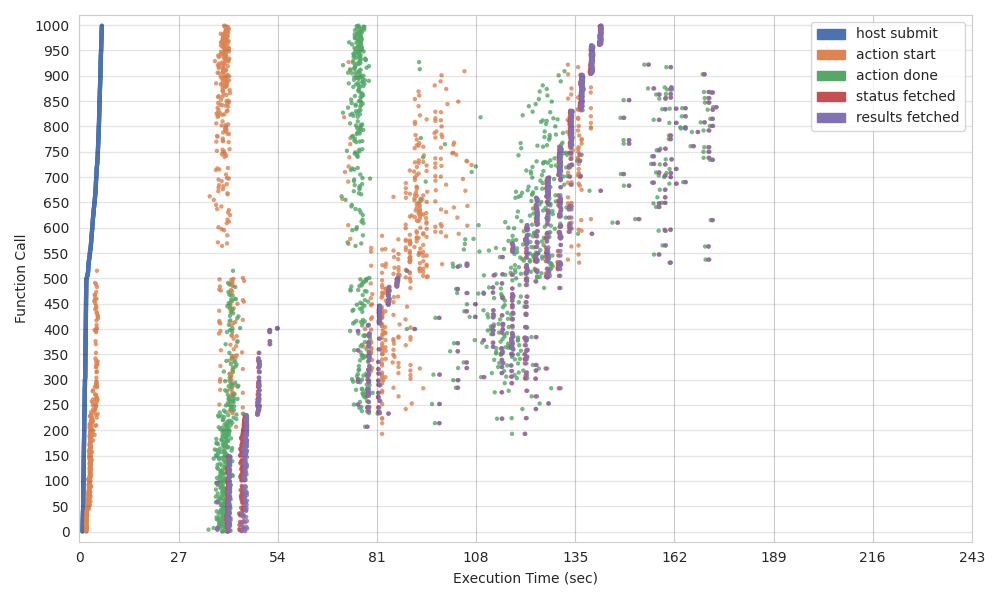

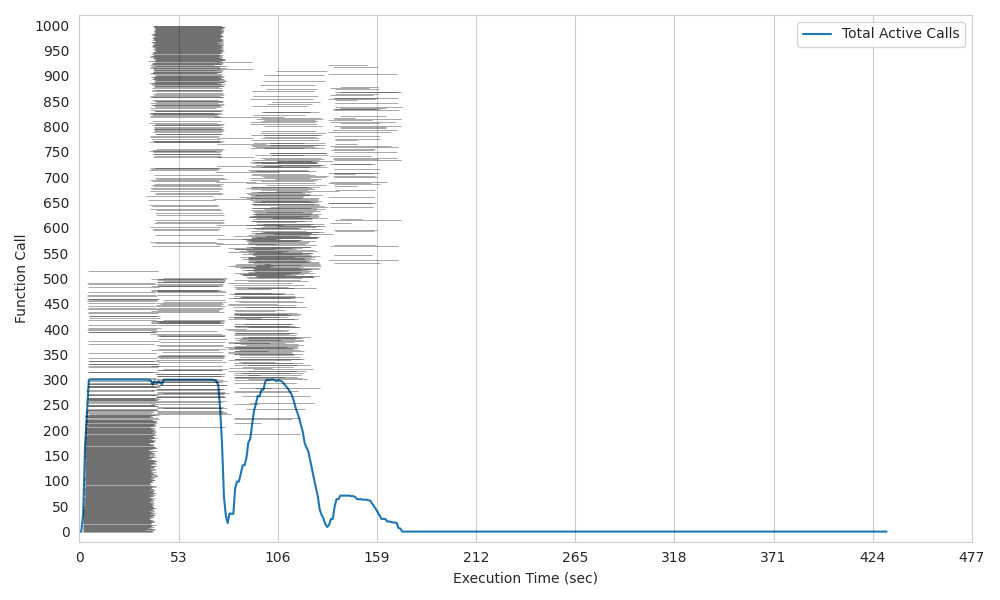

In [28]:
from IPython.display import display, Image
display(Image(filename='{}/{}_timeline.png'.format(COMPUTE_BACKEND, WORKERS)))
display(Image(filename='{}/{}_histogram.png'.format(COMPUTE_BACKEND, WORKERS)))


Let's plot the intra function FLOPS first:

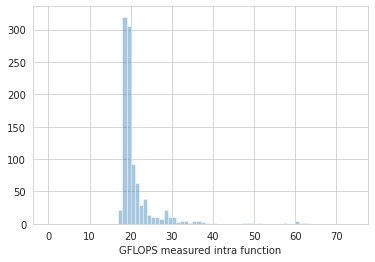

In [29]:
import flops_benchmark
exp_results = pickle.load(open("{}/{}.pickle".format(COMPUTE_BACKEND, WORKERS), 'rb'))
results_df = flops_benchmark.results_to_dataframe(exp_results)

flops = results_df.intra_func_flops/1e9
sns_plot = sns.distplot(flops, bins=np.arange(0, flops.max()*1.2), kde=False, axlabel='GFLOPS measured intra function')
sns_plot.figure.savefig("{}/{}_rates.png".format(COMPUTE_BACKEND, WORKERS))

Now let's aggregate this to understand our total GFLOPS across all the parallel executions and plot it:

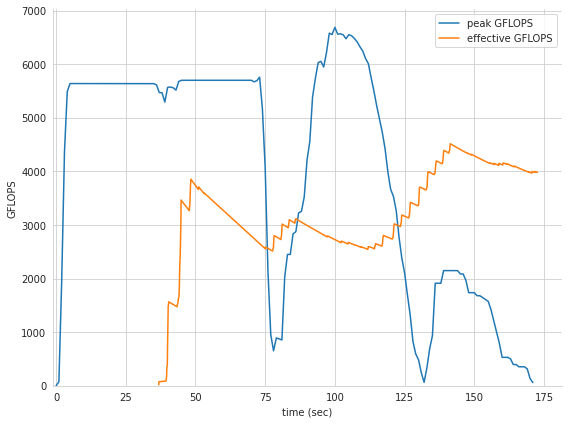

In [30]:
est_total_flops = results_df['est_flops']
total_jobs = len(results_df)
JOB_GFLOPS = est_total_flops /1e9 /total_jobs 
# grid jobs running time 
time_offset = np.unique(np.min(results_df.host_submit_time))
max_time = np.max(results_df.download_output_timestamp ) - time_offset
runtime_bins = np.linspace(0, int(max_time), int(max_time), endpoint=False)


runtime_flops_hist = np.zeros((len(results_df), len(runtime_bins)))
for i in range(len(results_df)):
    row = results_df.iloc[i]
    s = (row.start_time + row.setup_time) - time_offset
    e = row.end_time - time_offset
    a, b = np.searchsorted(runtime_bins, [s, e])
    a = a[0]
    b = b[0]
    if b-a > 0:
        runtime_flops_hist[i, a:b] = row.est_flops / float(b-a)
        
results_by_endtime = results_df.sort_values('download_output_timestamp')
results_by_endtime['job_endtime_zeroed'] = results_df.download_output_timestamp - time_offset
results_by_endtime['flops_done'] = results_by_endtime.est_flops.cumsum()
results_by_endtime['rolling_flops_rate'] = results_by_endtime.flops_done/results_by_endtime.job_endtime_zeroed

    
fig = pylab.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(runtime_flops_hist.sum(axis=0)/1e9, label='peak GFLOPS')
ax.plot(results_by_endtime.job_endtime_zeroed, 
        results_by_endtime.rolling_flops_rate/1e9, label='effective GFLOPS')
ax.set_xlabel('time (sec)')
ax.set_ylabel("GFLOPS")
ax.set_xlim(-1)
ax.set_ylim(-1)
pylab.legend()
ax.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig("{}/{}_gflops.png".format(COMPUTE_BACKEND, WORKERS))

This plot computes two things:
* **Peak GLFOPS**: Across all cores, what is the total simultaneous FLOPS that are being computed? 
* **Effective GFLOPS**: If the job ended at this point in time, what would our aggregate effective GFLOPS have been, including time to launch the jobs and download the results

We see "peak GFLOPS" peaks in the middle of the job, when all 1000 lambdas are running at once. "Effective GFLOPS" starts climbing as results quickly return, but stragglers mean that our total effective GFLOPS drops slightly. Still not bad for pure python! 